# Duke PAM Project - Undersampled PAM
## Title: Main Training Document
## Author: Anthony DiSpirito III
## Github: @adispirito
## Date: November 20, 2020

### pip installs/uninstalls

In [1]:
!pip3 uninstall tensorflow_datasets -y -q
!pip3 install git+git://github.com/axd465/datasets -q

### Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import shutil
from functools import partial
from tensorflow.image import random_crop, random_brightness, random_contrast, \
                             random_flip_left_right, random_flip_up_down, resize
if not os.path.exists('./utils') or not os.path.exists('./models'):
    print('Cloning Git Repo...')
    !git clone -q https://github.com/adispirito/BME590-Final_Project-Duke_PAM
    if not os.path.exists('./utils'):
        os.mkdir('./utils')
        os.rename('./BME590-Final_Project-Duke_PAM/utils', './utils')
    else:
        os.mkdir('./models')
        os.rename('./BME590-Final_Project-Duke_PAM/utils', './utils')
from utils.downsampling_utils import *
from utils.augmentation_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
AUTOTUNE = os.cpu_count()//2 #tf.data.experimental.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)

Tensorflow version: 2.3.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load Dataset

In [3]:
(train_ds, val_ds), metadata = tfds.load('duke_pam/clean', split=['train', 'validation'], with_info=True, data_dir = 'data')

## Model Training

### Setting Training Parameters

In [4]:
DOWNSAMPLING_METHOD = 'uniform' # 'uniform' or 'random'
SPARSITY = 1 - (1/9)
DOWN_RATIO = (3,3)

In [5]:
CROP_SIZE = (128, 128, 3)
rand_crop = partial(random_crop, size = CROP_SIZE)

In [6]:
PROB_OF_AUG = 1/3 # prob [0,1]
MAX_BRIGHT_SHIFT = 0.1 # in range [0,1]
LOWER_CONTRAST_FACTOR = 0.2
UPPER_CONTRAST_FACTOR = 1.8
GAUSS_NOISE_MEAN = 0
LOWER_GAUSS_NOISE_STD = 0.003
UPPER_GAUSS_NOISE_STD = 0.015
main_augment = partial(augment, prob = PROB_OF_AUG, max_shift = MAX_BRIGHT_SHIFT, 
                       lower_con_factor = LOWER_CONTRAST_FACTOR, upper_con_factor = UPPER_CONTRAST_FACTOR,
                       mean = GAUSS_NOISE_MEAN, std_lower = LOWER_GAUSS_NOISE_STD, 
                       std_upper = UPPER_GAUSS_NOISE_STD)

In [7]:
MAX_SHIFT_FRACTION_X_Y = [0.1, 0.1]
FILL_MODE = 'constant'
INTERP_ORD = 0 # No Interp

lambda_map_func = partial(keras_augment, fill_mode=FILL_MODE, interpolation_order=INTERP_ORD, 
                  max_width_shift = MAX_SHIFT_FRACTION_X_Y[0], max_height_shift = MAX_SHIFT_FRACTION_X_Y[1])
lambda_func = lambda x: tf.numpy_function(lambda_map_func, [x], tf.float32)

### Picking Downsampling Method

In [8]:
if DOWNSAMPLING_METHOD is 'random':
    down_map_func = partial(downsample_zerofill, sparsity=SPARSITY, min_shape = (CROP_SIZE[0], CROP_SIZE[1]))
    train_ds_down_zerofill_rand = train_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    val_ds_down_zerofill_rand = val_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    
    train_ds_aug_rand = (
        train_ds_down_zerofill_rand
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(main_augment, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(lambda_func, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    val_ds_aug_rand = (
        val_ds_down_zerofill_rand
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    ) 
else:
    down_map_func = partial(downsample_zerofill, down_ratio=DOWN_RATIO, min_shape = (CROP_SIZE[0], CROP_SIZE[1]))
    train_ds_down_zerofill = train_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    val_ds_down_zerofill = val_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    
    train_ds_aug = (
        train_ds_down_zerofill
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(main_augment, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(lambda_func, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    val_ds_aug = (
        val_ds_down_zerofill
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    ) 

### Shuffling Data and Batching

In [9]:
def custom_generator_wrapper(gen):
    '''
    This wrapper function ensures that the downsampled data and ground truth
    stay coaligned during the random crop step.
    '''
    for data in gen:
        orig_img = data[...,0] # target
        down_img = data[...,1] # input
        # mask_img = data[...,2] # mask
        yield down_img[..., None], orig_img[..., None]

In [47]:
# Import Model:
from models.UNet import getModel

In [48]:
# Hyperparameters:
STANDARD_IMAGE_SHAPE = (None, None, 1)
BATCH_SIZE = 16
EPOCHS = 100
FILTERS = 64
INITIAL_LR = 0.001
ACTIVATION = 'elu'       
KERNEL_SIZE = 3 # 3x3 kernel
AUGMENTATIONS = 10
VAL_AUGMENTATIONS = 10
MODEL_DIR = 'saved_models'
BUFFER_SIZE = 10000
NUM_TRAIN = metadata.splits['train'].num_examples
NUM_VAL = metadata.splits['validation'].num_examples
UPDATE_INFO_EVERY_X_EPOCHS = 22
delete_previous = True
SAVE_METRIC = 'val_SSIM'

In [49]:
if DOWNSAMPLING_METHOD is 'uniform':
    train_ds_aug_batch = train_ds_aug.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
    val_ds_aug_batch = val_ds_aug.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
else:
    train_ds_aug_batch = train_ds_aug_rand.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
    val_ds_aug_batch = val_ds_aug_rand.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

In [50]:
model = getModel(input_shape=STANDARD_IMAGE_SHAPE, filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION)

In [51]:
# Import Custom Loss Functions:
from utils.model_utils import SSIM
from utils.model_utils import PSNR

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR, amsgrad=False),  # pick an optimizer
              loss='mean_absolute_error',
              experimental_steps_per_execution = ((AUGMENTATIONS)*np.ceil(NUM_TRAIN/BATCH_SIZE))//UPDATE_INFO_EVERY_X_EPOCHS,
              metrics=['mean_absolute_error', 'mean_squared_error', SSIM, PSNR])

In [54]:
if not os.path.exists(MODEL_DIR):
            os.mkdir(MODEL_DIR)
elif delete_previous:
            shutil.rmtree(MODEL_DIR)
            os.mkdir(MODEL_DIR)

my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(MODEL_DIR, 'saved_model.epoch_{epoch:02d}-' + 
                                                                           SAVE_METRIC + '_{' + SAVE_METRIC + ':.5f}.h5'),
                                                   monitor='val_SSIM',
                                                   verbose=0, 
                                                   save_best_only=True, save_weights_only=False, 
                                                   mode='max', save_freq='epoch')]
            
history = model.fit(custom_generator_wrapper(train_ds_aug_batch),
                    steps_per_epoch=AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE),
                    epochs=EPOCHS,
                    callbacks=my_callbacks,
                    validation_data=custom_generator_wrapper(val_ds_aug_batch),
                    validation_steps=VAL_AUGMENTATIONS*np.ceil(NUM_VAL/BATCH_SIZE), 
                    max_queue_size=AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE))

Epoch 1/50
220/220 [==============================] - 95s 431ms/step - loss: 0.1098 - mean_absolute_error: 0.1098 - mean_squared_error: 0.5096 - SSIM: 0.3742 - PSNR: 16.8960 - val_loss: 0.1216 - val_mean_absolute_error: 0.1216 - val_mean_squared_error: 0.0496 - val_SSIM: 0.2113 - val_PSNR: 14.4032
Epoch 2/50
220/220 [==============================] - 91s 414ms/step - loss: 0.0496 - mean_absolute_error: 0.0496 - mean_squared_error: 0.1989 - SSIM: 0.5456 - PSNR: 20.4294 - val_loss: 0.1016 - val_mean_absolute_error: 0.1016 - val_mean_squared_error: 0.0267 - val_SSIM: 0.4429 - val_PSNR: 17.6573
Epoch 3/50
220/220 [==============================] - 92s 418ms/step - loss: 0.0404 - mean_absolute_error: 0.0404 - mean_squared_error: 0.0685 - SSIM: 0.6353 - PSNR: 22.3720 - val_loss: 0.0557 - val_mean_absolute_error: 0.0557 - val_mean_squared_error: 0.0076 - val_SSIM: 0.7827 - val_PSNR: 25.1919
Epoch 4/50
220/220 [==============================] - 91s 412ms/step - loss: 0.0385 - mean_absolute_err

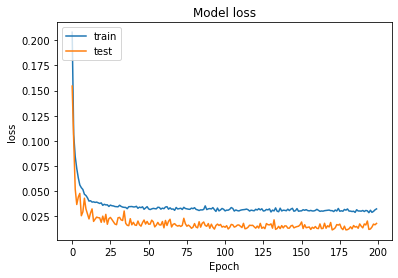

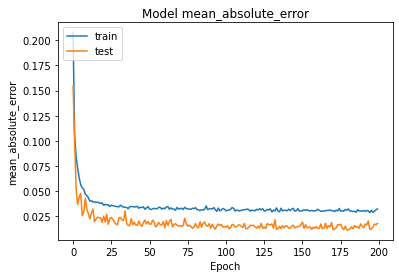

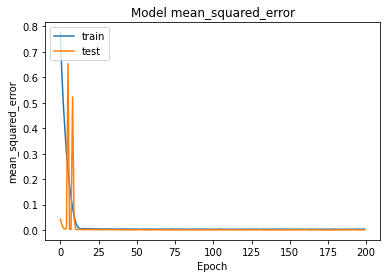

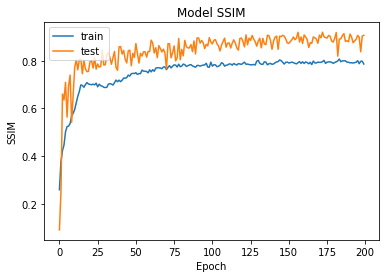

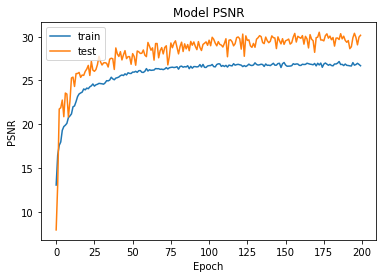

In [28]:
from utils.history_utils import show_history
offset = 0
show_history(history, offset)

### Save Model and History into Folder

In [52]:
from utils.history_utils import save_history

if not os.path.exists('./trained_models'):
    os.mkdir('./trained_models')
if DOWNSAMPLING_METHOD is 'random':
    output_dir = f'trained_models/saved_unet_rand_down_{int(np.round(SPARSITY*100))}p'
else:
    output_dir = f'trained_models/saved_unet_uni_down_{DOWN_RATIO[0]}_{DOWN_RATIO[1]}'

if not os.path.exists(output_dir):
    print('Creating Directory...')
    os.mkdir(output_dir)
else:
    print('Directory Already Exists...')
file_list = [file for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-')[0]))[-1]
old_path = os.path.join(MODEL_DIR, filename)
best_model_dir = os.path.join(output_dir, 'best_models')
new_path = os.path.join(best_model_dir, filename)
if not os.path.exists(best_model_dir):
    os.mkdir(best_model_dir)
print('Saving Best Model...')
os.rename(old_path, new_path)
print('Saving History...')
save_history(history, output_dir)
print('Done!!!')

Creating Directory...
Saving Best Model...
Saving History...
Done!!!
